In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_theme(style="whitegrid")

import os
from skimage import io, transform

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import sampler

import skimage.io as io
from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise
from skimage.filters import gaussian

import torchvision.transforms as T

import torchvision.datasets as dset
from torchvision import transforms, utils

import cv2

In [4]:
train_data = pd.read_csv('./data/cavy_data_train.csv')
val_data = pd.read_csv('./data/cavy_data_val.csv')
test_data = pd.read_csv('./data/cavy_data_test.csv')

In [16]:
print("train")
print(len(train_data[train_data["breed"] == "American"]), len(train_data[train_data["breed"] == "Abyssinian"]), len(train_data[train_data["breed"] == "Silkie"]),len(train_data[train_data["breed"] == "Skinny"]))

train
332 353 236 214


In [17]:
print("validation")
print(len(val_data[val_data["breed"] == "American"]), len(val_data[val_data["breed"] == "Abyssinian"]), len(val_data[val_data["breed"] == "Silkie"]),len(val_data[val_data["breed"] == "Skinny"]))

validation
83 89 59 53


In [18]:
print("test")
print(len(test_data[test_data["breed"] == "American"]), len(test_data[test_data["breed"] == "Abyssinian"]), len(test_data[test_data["breed"] == "Silkie"]),len(test_data[test_data["breed"] == "Skinny"]))

test
104 111 74 66


In [4]:
def split_count(x):
    """
    Args:
        x (pd.Series)
    Returns:
        res (pd.DataFrame)
    """
    assert isinstance(x,pd.Series)
    res = x.str.split(', ').explode().value_counts()
    res = pd.DataFrame(index=res.index,data=res.values,columns=['count'])
    return res

In [7]:
train_breeds = split_count(train_data['breed'])
val_breeds = split_count(val_data['breed'])
test_breeds = split_count(test_data['breed'])

Text(0.5, 0.98, 'Breed Distribution across Training, Validation & Test Datasets')

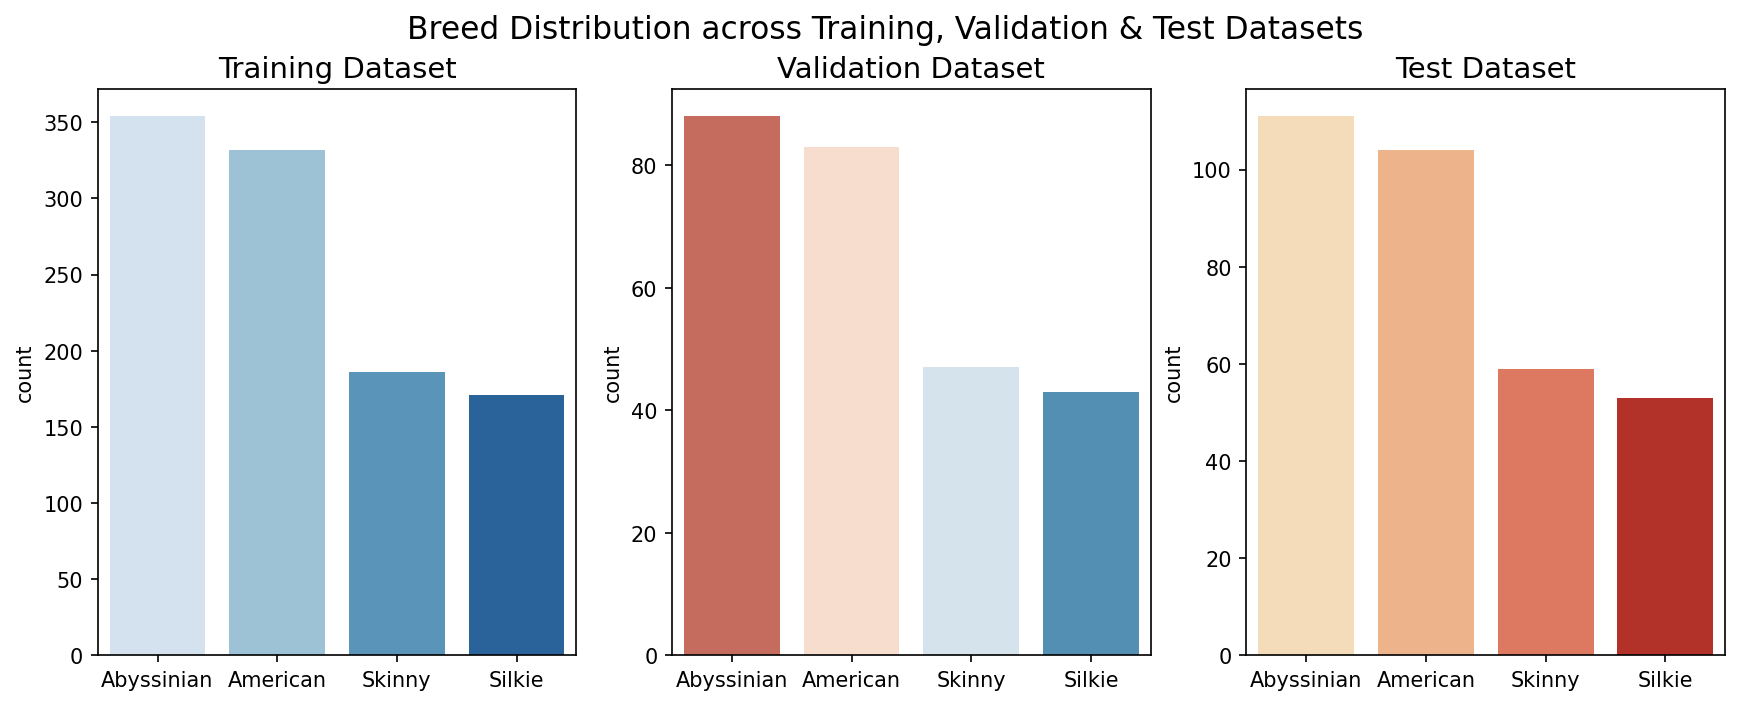

In [15]:
fig, axs = plt.subplots(1,3, dpi = 150, figsize=(14, 5))

sns.barplot(ax = axs[0], x=train_breeds.index, y='count', data=train_breeds, palette = "Blues")
axs[0].set_title("Training Dataset", size = 14)
sns.barplot(ax = axs[1], x=val_breeds.index, y='count', data=val_breeds, palette = "RdBu")
axs[1].set_title("Validation Dataset", size = 14)
sns.barplot(ax = axs[2], x=test_breeds.index, y='count', data=test_breeds, palette = "OrRd")
axs[2].set_title("Test Dataset", size = 14)
fig.suptitle('Breed Distribution across Training, Validation & Test Datasets', size = 15)

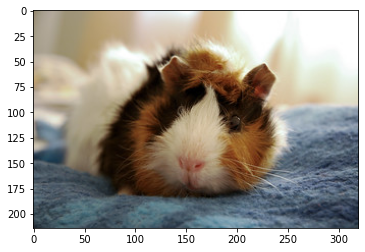

In [220]:
image = cv2.cvtColor(cv2.imread(os.path.join('./cavy_breed_clf', val_data["image_path"][23])),cv2.COLOR_BGR2RGB)
plt.grid(False)
plt.imshow(image)

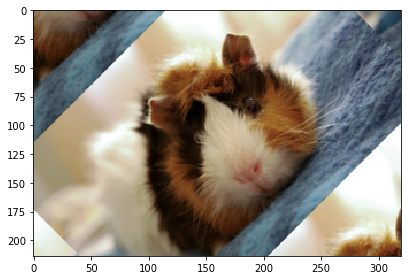

In [221]:
rotated = rotate(image, angle=45, mode = 'wrap')
plt.grid(False)

io.imshow(rotated)

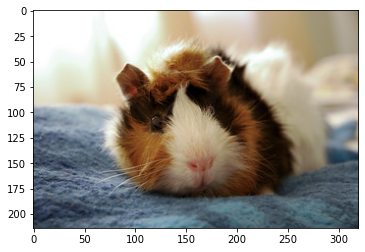

In [222]:
flipLR = np.fliplr(image)
plt.grid(False)
plt.imshow(flipLR)


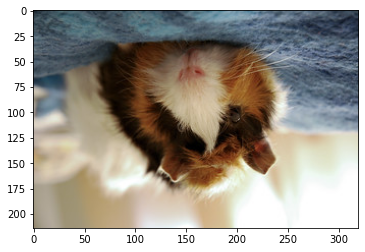

In [223]:
flipUD = np.flipud(image)
plt.grid(False)
plt.imshow(flipUD)


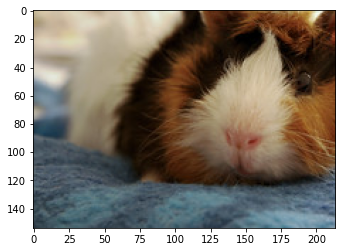

In [229]:
#centercrop the image
img = image
center1 = image.shape[0] / 2
center2 = image.shape[1] / 2

x = center1 - 100
y = center2 - 100

crop_img = img[int(y):int(y+image.shape[1]), int(x):int(x+image.shape[0])]

plt.grid(False)
plt.imshow(crop_img)


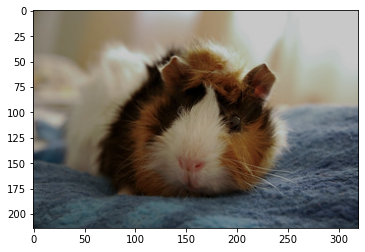

In [232]:
#normalization
norm = cv2.normalize(image, None, alpha=0,beta=200, norm_type=cv2.NORM_MINMAX)
plt.grid(False)
plt.imshow(norm)


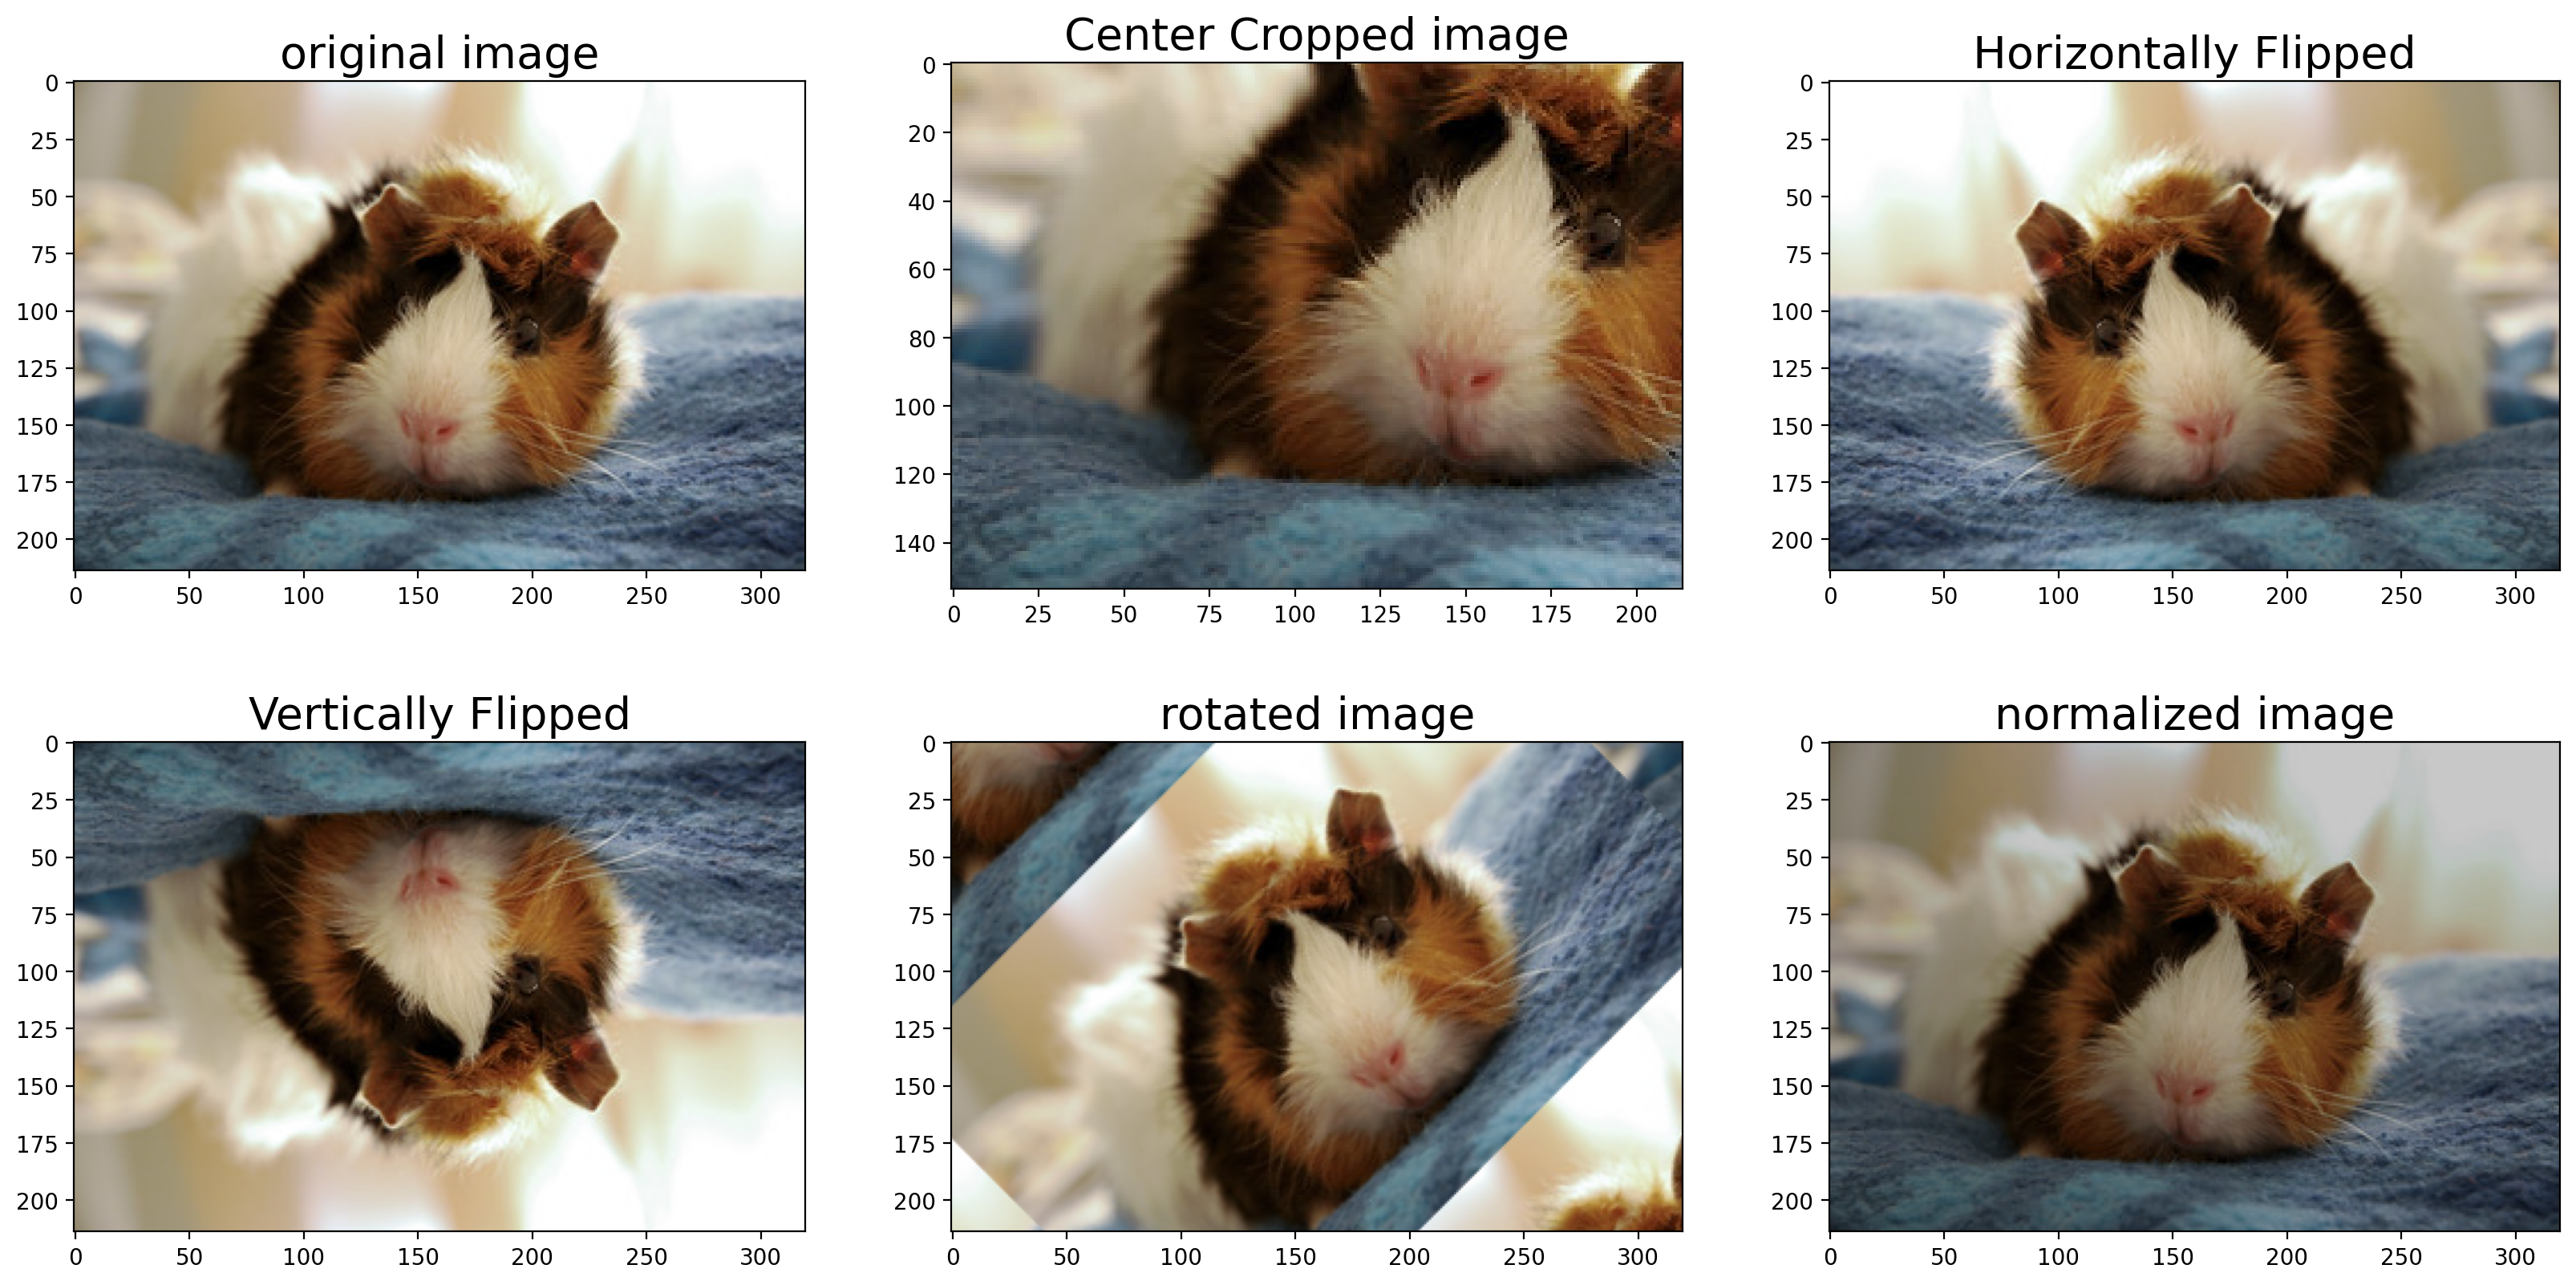

In [240]:
aug = []
aug.append(image)
# aug.append(out)
aug.append(crop_img)
aug.append(flipLR)
aug.append(flipUD)

aug.append(rotated)
aug.append(norm)
fig,ax = plt.subplots(nrows=2,ncols=3,dpi = 200, figsize=(20,10))
ax[0,0].set_title("original image", fontsize = 20)
ax[0,1].set_title("Center Cropped image", fontsize = 20)
ax[0,2].set_title("Horizontally Flipped", fontsize = 20)
ax[1,0].set_title("Vertically Flipped", fontsize = 20)
ax[1,1].set_title("rotated image", fontsize = 20)
ax[1,2].set_title("normalized image", fontsize = 20)


plt.grid(False)
for i in range(2):
    for j in range(3):
        ax[i, j].imshow(aug[i*3+j])


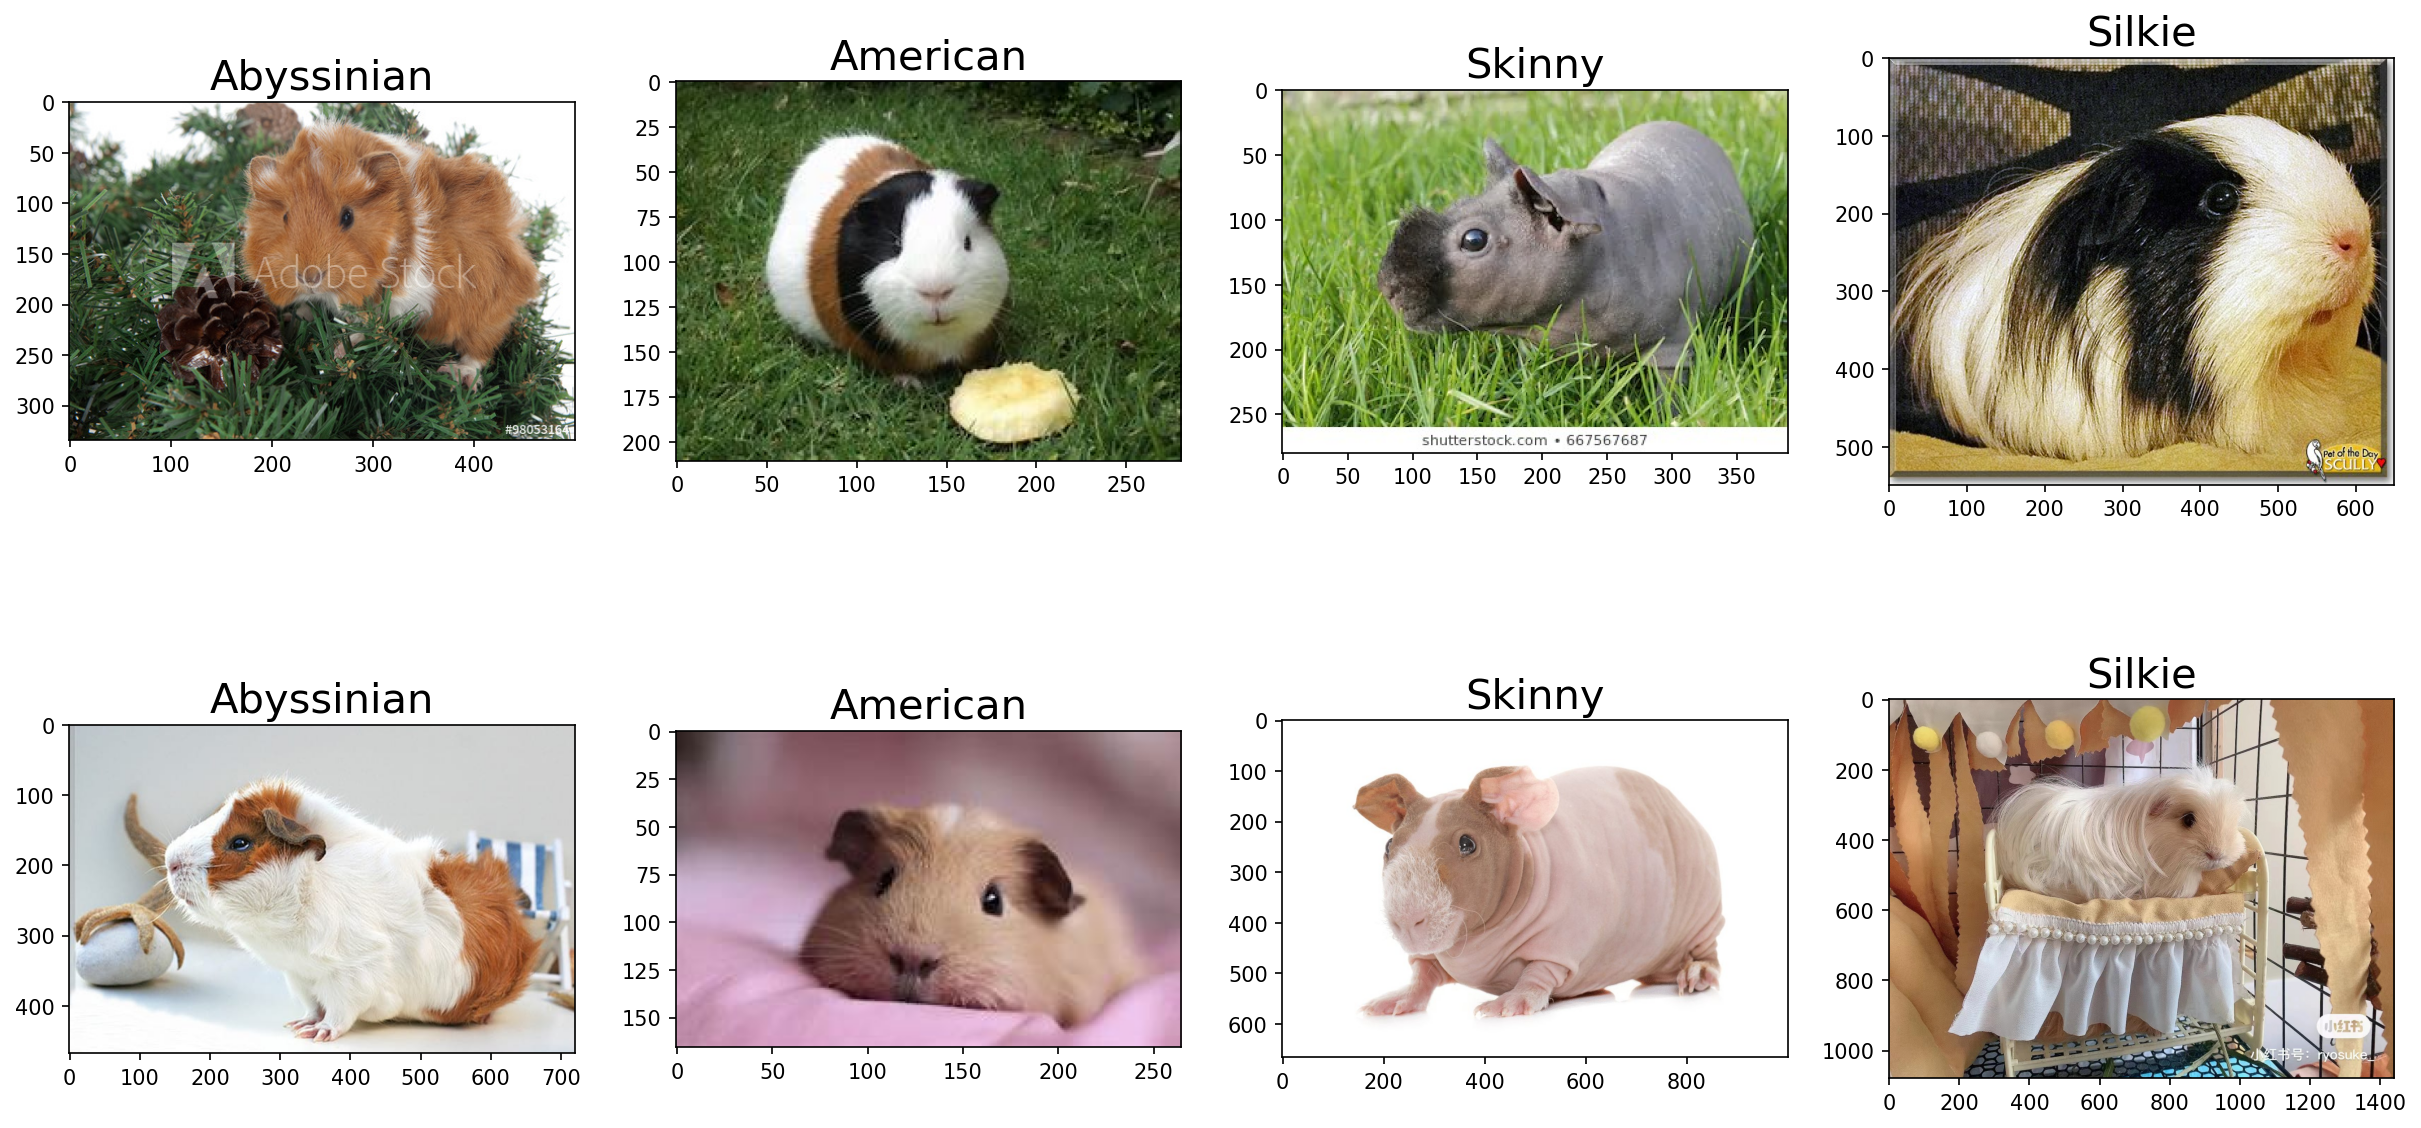

In [120]:
ab1 = cv2.cvtColor(cv2.imread(os.path.join('./cavy_breed_clf', test_data["image_path"][21])),cv2.COLOR_BGR2RGB)
ab2 = cv2.cvtColor(cv2.imread(os.path.join('./cavy_breed_clf', test_data["image_path"][342])),cv2.COLOR_BGR2RGB)

am1 = cv2.cvtColor(cv2.imread(os.path.join('./cavy_breed_clf', train_data["image_path"][1])),cv2.COLOR_BGR2RGB)
am2 = cv2.cvtColor(cv2.imread(os.path.join('./cavy_breed_clf', train_data["image_path"][109])),cv2.COLOR_BGR2RGB)

sk1 = cv2.cvtColor(cv2.imread(os.path.join('./cavy_breed_clf', train_data["image_path"][114])),cv2.COLOR_BGR2RGB)
sk2 = cv2.cvtColor(cv2.imread(os.path.join('./cavy_breed_clf', test_data["image_path"][354])),cv2.COLOR_BGR2RGB)

si1 = cv2.cvtColor(cv2.imread(os.path.join('./cavy_breed_clf', train_data["image_path"][20])),cv2.COLOR_BGR2RGB)
si2 = cv2.cvtColor(cv2.imread(os.path.join('./cavy_breed_clf', train_data["image_path"][25])),cv2.COLOR_BGR2RGB)

aug = []
aug.append(ab1)
aug.append(am1)
aug.append(sk1)
aug.append(si1)
aug.append(ab2)
aug.append(am2)
aug.append(sk2)
aug.append(si2)
# aug.append(noisyRandom)
fig,ax = plt.subplots(nrows=2,ncols=4,dpi = 150, figsize = (20,10))
ax[0,0].set_title(test_data["breed"][21], fontsize = 20)
ax[0,1].set_title(train_data["breed"][1], fontsize = 20)
ax[0,2].set_title(train_data["breed"][114], fontsize = 20)
ax[0,3].set_title(train_data["breed"][20], fontsize = 20)
ax[1,0].set_title(test_data["breed"][342], fontsize = 20)
ax[1,1].set_title(train_data["breed"][109], fontsize = 20)
ax[1,2].set_title(test_data["breed"][354], fontsize = 20)
ax[1,3].set_title(train_data["breed"][25], fontsize = 20)



plt.grid(False)
for i in range(2):
    for j in range(4):
        ax[i,j].imshow(aug[i*4+j])
